In [13]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [14]:
class DecisionTree:
    def __init__(self, max_depth=10):
        self.max_depth = max_depth
        self.tree = None

    def fit(self, features, labels):
        self.tree = self._build_tree(features, labels)

    def predict(self, features):
        return [self._predict_sample(sample, self.tree) for sample in features]

    def _build_tree(self, features, labels, depth=0):
        unique_classes = np.unique(labels)
        if len(unique_classes) == 1:
            return unique_classes[0]
        if depth >= self.max_depth:
            return Counter(labels).most_common(1)[0][0]
        
        best_split = self._get_best_split(features, labels)
        left_tree = self._build_tree(best_split['left_features'], best_split['left_labels'], depth + 1)
        right_tree = self._build_tree(best_split['right_features'], best_split['right_labels'], depth + 1)
        return {'split': best_split['split'], 'left': left_tree, 'right': right_tree}

    def _get_best_split(self, features, labels):
        best_split = {}
        best_gini = float('inf')
        _ , n_features = features.shape
        for feature_index in range(n_features):
            unique_values = np.unique(features[:, feature_index])
            for value in unique_values:
                left_mask = features[:, feature_index] <= value
                right_mask = ~left_mask
                left_features, right_features = features[left_mask], features[right_mask]
                left_labels, right_labels = labels[left_mask], labels[right_mask]
                gini = self._calculate_gini(left_labels, right_labels)
                if gini < best_gini:
                    best_gini = gini
                    best_split = {'split': (feature_index, value),
                                  'left_features': left_features, 'left_labels': left_labels,
                                  'right_features': right_features, 'right_labels': right_labels}
        return best_split

    def _calculate_gini(self, left_labels, right_labels):
        total_samples = len(left_labels) + len(right_labels)
        left_size = len(left_labels) / total_samples
        right_size = len(right_labels) / total_samples
        left_gini = 1 - sum([(np.sum(left_labels == c) / len(left_labels)) ** 2 for c in np.unique(left_labels)])
        right_gini = 1 - sum([(np.sum(right_labels == c) / len(right_labels)) ** 2 for c in np.unique(right_labels)])
        return left_size * left_gini + right_size * right_gini

    def _predict_sample(self, sample, tree):
        if not isinstance(tree, dict):
            return tree
        feature_index, value = tree['split']
        if sample[feature_index] <= value:
            return self._predict_sample(sample, tree['left'])
        else:
            return self._predict_sample(sample, tree['right'])

In [15]:
class RandomForest:
    def __init__(self, n_trees=100, max_depth=10, random_state=42):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.random_state = random_state
        random.seed(self.random_state)
        np.random.seed(self.random_state)
        self.trees = []

    def fit(self, features, labels):
        for _ in range(self.n_trees):
            tree = DecisionTree(max_depth=self.max_depth)
            features_sample, labels_sample = self._bootstrap_sample(features, labels)
            tree.fit(features_sample, labels_sample)
            self.trees.append(tree)

    def predict(self, features):
        tree_predictions = np.zeros((len(features), self.n_trees))
        for i, tree in enumerate(self.trees):
            tree_predictions[:, i] = tree.predict(features)
        return np.array([Counter(x).most_common(1)[0][0] for x in tree_predictions])

    def _bootstrap_sample(self, features, labels):
        n_samples = len(features)
        indices = np.random.choice(range(n_samples), size=n_samples, replace=True)
        return features[indices], labels[indices]

In [16]:
class KNN:
    def __init__(self, k=5, random_state=42):
        self.k = k
        self.random_state = random_state
        random.seed(self.random_state)
        np.random.seed(self.random_state)

    def fit(self, features, labels):
        self.X_train = features
        self.y_train = labels

    def predict(self, features):
        return [self._predict_sample(sample) for sample in features]

    def _predict_sample(self, sample):
        distances = [np.linalg.norm(sample - train_sample) for train_sample in self.X_train]
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = self.y_train[k_indices]
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]

In [17]:
class GradientBoosting:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.random_state = random_state
        random.seed(self.random_state)
        np.random.seed(self.random_state)
        self.models = []

    def fit(self, features, labels):
        residuals = labels
        for _ in range(self.n_estimators):
            model = DecisionTree(max_depth=self.max_depth)
            model.fit(features, residuals)
            prediction = model.predict(features)
            residuals = labels - prediction
            self.models.append(model)

    def predict(self, features):
        predictions = np.zeros(len(features))
        for model in self.models:
            predictions += self.learning_rate * np.array(model.predict(features))
        return np.round(predictions).astype(int)

In [18]:
class Ensemble:
    def __init__(self, rf_params=None, gb_params=None, knn_params=None):
        self.rf = RandomForest(**rf_params)
        self.gb = GradientBoosting(**gb_params)
        self.knn = KNN(**knn_params)

    def fit(self, features, labels):
        self.rf.fit(features, labels)
        self.gb.fit(features, labels)
        self.knn.fit(features, labels)

    def predict(self, features):
        rf_pred = self.rf.predict(features)
        gb_pred = self.gb.predict(features)
        knn_pred = self.knn.predict(features)
        combined = np.array([rf_pred, gb_pred, knn_pred]).T
        return np.array([Counter(x).most_common(1)[0][0] for x in combined])

In [19]:
def create_and_preprocess_data():
    data = load_iris()
    features, labels = data.data, data.target
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    return train_test_split(features_scaled, labels, test_size=0.3, random_state=42)

def plot_confusion_matrix(true_labels, predicted_labels, title):
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

In [20]:
# Data preparation
X_train, X_test, y_train, y_test = create_and_preprocess_data()

rf_params = {
    "n_trees": 100,
    "max_depth": 10,
    "random_state": 42
}
gb_params = {
    "n_estimators": 200,
    "learning_rate": 0.05,
    "max_depth": 5,
    "random_state": 42
}
knn_params = {
    "k": 5,
    "random_state": 42
}

In [21]:
# Training individual models
rf_model = RandomForest(**rf_params)
gb_model = GradientBoosting(**gb_params)
knn_model = KNN(**knn_params)
ensemble_model = Ensemble(rf_params, gb_params, knn_params)

rf_model.fit(X_train, y_train)
gb_model.fit(X_train, y_train)
knn_model.fit(X_train, y_train)
ensemble_model.fit(X_train, y_train)

In [22]:
# Predictions
rf_pred = rf_model.predict(X_test)
gb_pred = gb_model.predict(X_test)
knn_pred = knn_model.predict(X_test)
ensemble_pred = ensemble_model.predict(X_test)

In [23]:
# Evaluation
rf_acc = accuracy_score(y_test, rf_pred)
gb_acc = accuracy_score(y_test, gb_pred)
knn_acc = accuracy_score(y_test, knn_pred)
ensemble_acc = accuracy_score(y_test, ensemble_pred)

In [24]:
results = pd.DataFrame({
    "Model": ["Random Forest", "Gradient Boosting", "KNN", "Ensemble"],
    "Accuracy": [rf_acc, gb_acc, knn_acc, ensemble_acc]
})

print("Model Comparison:\n", results)

Model Comparison:
                Model  Accuracy
0      Random Forest  1.000000
1  Gradient Boosting  0.422222
2                KNN  1.000000
3           Ensemble  1.000000


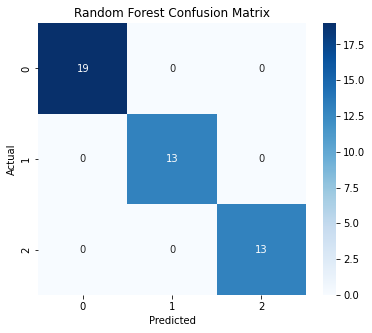

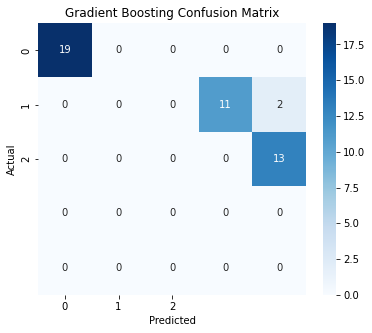

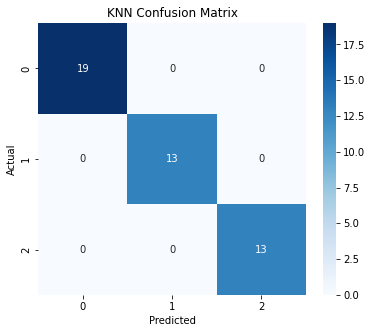

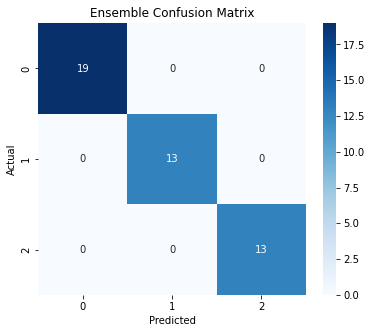

In [25]:
plot_confusion_matrix(y_test, rf_pred, "Random Forest Confusion Matrix")
plot_confusion_matrix(y_test, gb_pred, "Gradient Boosting Confusion Matrix")
plot_confusion_matrix(y_test, knn_pred, "KNN Confusion Matrix")
plot_confusion_matrix(y_test, ensemble_pred, "Ensemble Confusion Matrix")

In [26]:
# Classification reports
print("Random Forest Classification Report:")
print(classification_report(y_test, rf_pred))
print("Gradient Boosting Classification Report:")
print(classification_report(y_test, gb_pred, zero_division=1))
print("KNN Classification Report:")
print(classification_report(y_test, knn_pred))
print("Ensemble Classification Report:")
print(classification_report(y_test, ensemble_pred))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        13

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      0.00      0.00        13
           2       1.00      0.00      0.00        13
           5       0.00      1.00      0.00         0
          10       0.00      1.00      0.00         0

    accuracy                           0.42        45
   macro avg       0.60      0.60      0.20        45
weighted avg       1.00      0.42      0.42        45

KNN Classification Report:
              precision  